# Transferência de Estilo - Peixe Babel

Com base no tutorial de Neural Style Transfer do PyTorch:<br>
https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

---


### Explicação breve

#### A ideia aqui é a partir de duas imagens: (1) a imagem de entrada e (2) o estilo de referência se produza uma terceira imagem com o mesmo conteúdo da primeira, mas com propriedades de estilo da segunda. Como a transferência de estilo de um quadro de Picasso na imagem a seguir <sub><sup>[ feita com esse tutorial ;) ]</sup><sub>

![](https://drive.google.com/uc?export=view&id=16DWjVPwmtU6T5kb81i_u40LVzl2w3T-k)

<br>

Esse é um problema que não pode ser solucionado com aprendizado supervisionado tradicional, que depende de pares `(amostra, rótulo)`. Pra que isso fosse possível, deveríamos ter previamente uma quantidade substancial de imagens e suas versões estilizadas.
> Pra isso teríamos que, por exemplo, reviver o Van Gogh pra rotular uns dados.<br>
![](https://drive.google.com/uc?export=view&id=1tVzSA3EPPli8T5PY34BjyJVJMBzs5vVK)


Um dos primeiros algoritmos a obter resultados interessantes propôs a abordagem que hoje é tutorial de Transferência de Estilo no framework do PyTorch. Sua ideia consiste em extrair **métricas de conteúdo e estilo** das imagens e em vez de otimizar os pesos da rede, **otimizar os pixels da imagem**!!

Vamos conhecer um pouco sobre as métricas:

* **Métrica de conteúdo**: a imagem de entrada e a imagem modificada devem se parecer. Pra isso usamos uma função de custo de reconstrução, a `MSELoss`.

![](https://drive.google.com/uc?export=view&id=1J2ZW67KnDLg15seWrFoErVtAajHxApYW)

* **Métrica de estilo**: a imagem modificada deve conter as mesmas propriedades **de textura** da imagem de estilo dada como referência. Aqui também usamos uma métrica de reconstrução/regressão, porém comparando as **matrizes Gram*** da imagem estilo e da imagem modificada.<br>
<sub>Matriz Gram: conceito da álgebra linear que se calcula a partir do produto interno da matriz de features com ela mesma.

![](https://drive.google.com/uc?export=view&id=1rnzCRfHRe1wY8d61z3UUQvFAVakP0GN_)


<br><br>
A imagem abaixo, retirada diretamente do artigo [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf), enfatiza a influência do estilo da cena (codificado a partir da matriz Gram) em diferentes camadas de uma rede convolucional. Enquanto as primeiras camadas codificam informação de baixo nível, como traços e cores, as últimas camadas possui informação de alto nível, como as formas espirais notórias do Van Gogh e os focos de luz do quadro original. Por isso, a **métrica de estilo deve ser calculada para diferentes camadas do modelo**, garantindo que as informações de baixo até o alto nível da imagem modificada serão similares ao estilo de referência. 

![](https://drive.google.com/uc?export=view&id=1BWQf50SFSSZ-NbaPbPXQaX79-kLO2pHU)


In [5]:
from __future__ import print_function

import torch, os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

### Suba primeira a imagem que quer alterar e depois o estilo de referência

In [6]:
if not os.path.isfile('image.jpg'):
  uploaded = files.upload()
  
  foto = list(uploaded.keys())
  os.rename(foto[-1], 'imagem.jpg' )
  foto[-1] = 'imagem.jpg'
  
if not os.path.isfile('estilo.jpg'):
  uploaded = files.upload()
  
  estilo = list(uploaded.keys())
  os.rename(estilo[-1], 'estilo.jpg')
  estilo[-1] = 'estilo.jpg'

Saving image.jpg to image.jpg


Saving 1.jpg to 1.jpg


### Hiperparâmetros e Carregamento da imagem como Tensor
Aqui vamos definir os hiperparâmetros do método no dicionário `args`. São os mesmos hiperparâmetros do tutorial do PyTorch. 
* `img_size`: Tamanho das imagens de entrada e estilo
* `num_steps`: Quantas iterações de otimização o modelo deve fazer
* `style_weight` e `content_weight`: Peso de cada parte da métrica de qualidade (estilo e conteúdo)

Para adequar as imagens definimos um método de carregamento comum a todas. O principal requisito é que ambas as imagens tenham **o mesmo tamanho** (aqui definido como `512 x 512`)

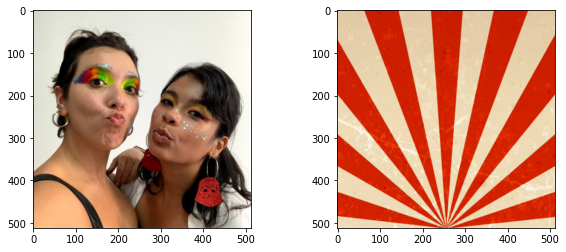

In [8]:
args = {
    'img_size': 512,
    'num_steps': 300,
    'style_weight': 1000000, 
    'content_weight': 1
}

args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loader = transforms.Compose([
    transforms.Resize((args['img_size'])),  # scale imported image
    transforms.CenterCrop(((args['img_size']), (args['img_size']))),
    transforms.ToTensor(),  # transform it into a torch tensor
    # transforms.Normalize(
    #     [0.485, 0.456, 0.406],
    #     [0.229, 0.224, 0.225]
    # )
    ])
    

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(args['device'], torch.float)

style_img = image_loader("estilo.jpg")
content_img = image_loader("imagem.jpg")

fig, axs = plt.subplots(1,2, figsize=(10, 4))
axs[0].imshow(content_img[0].permute(1,2,0).cpu().detach())
axs[1].imshow(style_img[0].permute(1,2,0).cpu().detach())
plt.show()

## Funções de Custo

A princípio vamos definir as métricas de conteúdo e estilo como classes do tipo ``nn.Module``, isso porque **elas serão incluídas como camadas da nossa rede**! Observe os `__init__()` das classes `ContentLoss` e `StyleLoss`, ambos já guardam os objetos (1) da imagem de entrada e (2) da matrix Gram da imagem estilo. Eles serão sempre usados para comparar com a imagem modificada que estamos produzindo.

> Objeto Module do PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

Note que a métrica de estilo está dividida em:
* uma função auxiliar para calcular a matriz Gram
* a classe que será incluída como camada da rede.

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

############ Style Loss ############
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Definição do Modelo

> Vale a pena voltar na imagem da arquitetura no início desse documento pra que essa explicação faça sentido.

Essa é a parte em que vamos construir nosso modelo **totalmente convolucional** com bifurcações que irão compor as métricas de contéudo e estilo como camadas da rede. Vamos usar como referência a **`VGG19`** pré-treinada para classificação de objetos. Isso significa que seus pesos são excelentes pra modelar características relevantes de uma cena :) 


Temos que definir que níveis da rede servirão de referência para avaliar o conteúdo e um outro conjunto de níveis para avaliar o estilo. No código a seguir definimos que:
* **A métrica de conteúdo será calculada a partir da saída da camada `conv4`;**
* **A métrica de estilo será um acumulado das saídas das camadas `conv1` a `conv5`.** 

Lembrando, isso significa que nos importamos apenas com o conteúdo original da cena em alto nível (algo mais global), enquanto o estilo deve ser otimizado em diferentes níveis, pra que a textura de baixo, médio e alto nível sejam similares ao estilo de referência.


In [10]:
cnn = models.vgg19(pretrained=True).features.to(args['device']).eval()

content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

content_losses = []
style_losses = []

# Criando o modelo 
model = nn.Sequential()
i = 0  # increment every time we see a conv
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
        # add content loss:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        # add style loss:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)

# now we trim off the layers after the last content and style losses
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break

model = model[:(i + 1)]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


## Otimização

Essa parte é interessante pelo seguinte: em geral, ao definir o otimizador do nosso problema, ele é colocado em termos dos parâmetros da rede. Nesse caso, **nosso conjunto de valores a serem otimizados são os pixels da imagem de entrada**!

Criamos portanto uma cópia da imagem de entrada (pois a original vai ser utilizada nas métricas), e a cada passo de otimização, os pixels da entrada serão alterados de acordo com as perdas calculadas em cada bifurcação do algoritmo!

Text(0.5, 1.0, 'Input Image')

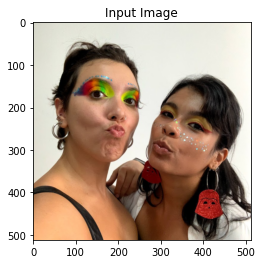

In [11]:
#### Optimizer
input_img = content_img.clone()
optimizer = optim.LBFGS([input_img.requires_grad_()])

plt.figure()
plt.imshow(input_img[0].permute(1,2,0).cpu().detach())
plt.title('Input Image')

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados (é uma imagem só e já tá carregada)
* Zerar os gradientes do otimizador
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passo de otimização

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [12]:
print('Optimizing..')
run = [0]
while run[0] <= args['num_steps']-100:

    def closure():
        # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      # Zere os gradientes
      optimizer.zero_grad()

      # Forward do dado na rede
      model(input_img)

      # Cálculo das Losses
      style_score = 0
      content_score = 0

      for sl in style_losses:
          style_score += sl.loss
      for cl in content_losses:
          content_score += cl.loss

      style_score *= args['style_weight']
      content_score *= args['content_weight']

      loss = style_score + content_score

      # Cálculo dos gradientes a partir da loss
      loss.backward()
      
      # Plot para acompanhar a convergência
      run[0] += 1
      if run[0] % 50 == 0:
          print("run {}:".format(run))
          print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              style_score.item(), content_score.item()))
          print()

      return style_score + content_score

    # Passo de otimização!
    optimizer.step(closure)

# a last correction...
output = input_img.data.clamp_(0, 1)

Optimizing..
run [50]:
Style Loss : 3.882977 Content Loss: 2.245108

run [100]:
Style Loss : 0.883900 Content Loss: 2.019978

run [150]:
Style Loss : 0.505025 Content Loss: 1.981132

run [200]:
Style Loss : 0.411035 Content Loss: 1.958066



### Imprimindo o resultado!

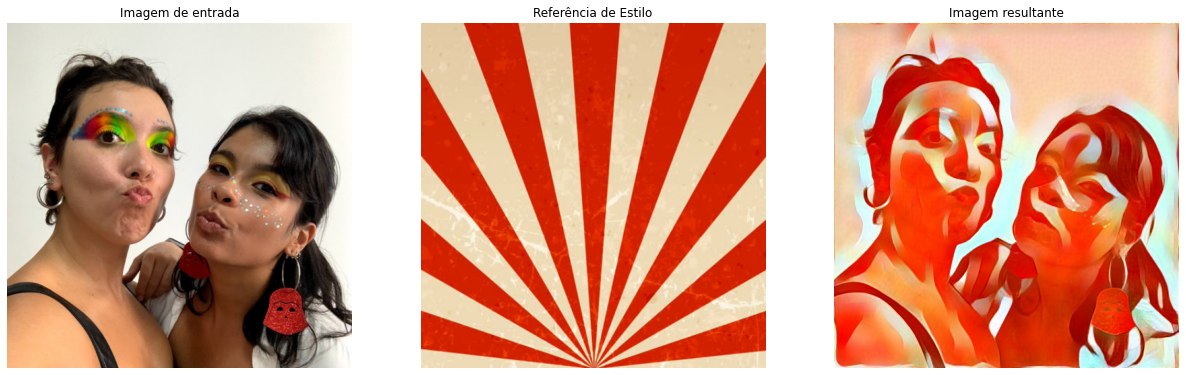

In [13]:
fig, axs = plt.subplots(1,3, figsize=(21, 8))
axs[0].imshow(content_img[0].permute(1,2,0).cpu().detach())
axs[0].set(title='Imagem de entrada')
axs[0].axis('off')
axs[1].imshow(style_img[0].permute(1,2,0).cpu().detach())
axs[1].set(title='Referência de Estilo')
axs[1].axis('off')
axs[2].imshow(output[0].permute(1,2,0).cpu().detach())
axs[2].set(title='Imagem resultante')
axs[2].axis('off')
plt.show()

# Quer entender ainda mais?

Seja sobre a base de redes neurais em geral ou as redes convolucionais em específico, tem cursos de autoria Babelística (nossa) na plataforma da Alura!

- Redes Neurais: Deep Learning com PyTorch<br>
https://www.alura.com.br/curso-online-pln-deep-learning

- Treinando uma Rede Neural: Deep Learning com PyTorch <br>
https://www.alura.com.br/curso-online-treinando-rede-neural-pytorch

- Redes Neurais Convolucionais: Deep Learning com PyTorch <br>
https://www.alura.com.br/curso-online-cnn-redes-neurais-convolucionais-deep-learning-pytorch

